## 3D Reflectivity Height Interpolation for derived dBZ of WRF Simulations. 

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211013**

In [10]:
import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

# import metpy
# import metpy.calc as mpcalc
# import metpy.units as units
# print(metpy.__version__)
# import dask


**Set input files paths and names:**

In [11]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

In [12]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'

## Set date time:
# case_date_time = dt.datetime(2011,4,27) 
case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2013/wrf3d_d01_CTRL_dbz_20130913.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2013/wrf3d_d01_CTRL_Z_20130913.nc'}


**Deploy wrf.interplevel directly:**

In [13]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 0

## Set interpolation height:
interp_vertical_lev = 3000 # meter in height.

## Get dBZ and the vertical coordinate for interpolation:
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)

## dBZ Interpolation directly:
# dbz_lev = interplevel(da_wrf_dbz, data_wrf_z_unstag, interp_vertical_lev)

## (dB)Z interpolation linearly:
da_wrf_dbz = 10**(da_wrf_dbz/10.) # Use linear Z for interpolation
dbz_lev = interplevel(da_wrf_dbz, data_wrf_z_unstag, interp_vertical_lev)
dbz_lev = 10.0 * np.log10(dbz_lev) # Convert back to dBz after interpolation

dbz_lev = dbz_lev.assign_attrs(vert_units='m')


**Save interpolated field to temporary file (if needed):**

In [14]:
# dbz_lev.to_netcdf('/glade/scratch/hungjui/temp/dbz_lev_{}_{}.nc'.format(interp_vertical_lev[0], np.datetime_as_string(dbz_lev.Time.data, unit='h')))
# write_xarray_to_netcdf(dbz_lev, '/glade/scratch/hungjui/temp/tmp_dbz_lev.nc')

### Test plot:

**Set colorbars:**

In [15]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
# clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

**Function: creating new map:**

In [16]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    # ax.set_extent([-139, -55, 16, 60], crs=proj)
    # ax.set_extent([-96, -84, 33, 41], crs=proj)
    ax.set_extent([-115, -95, 32, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


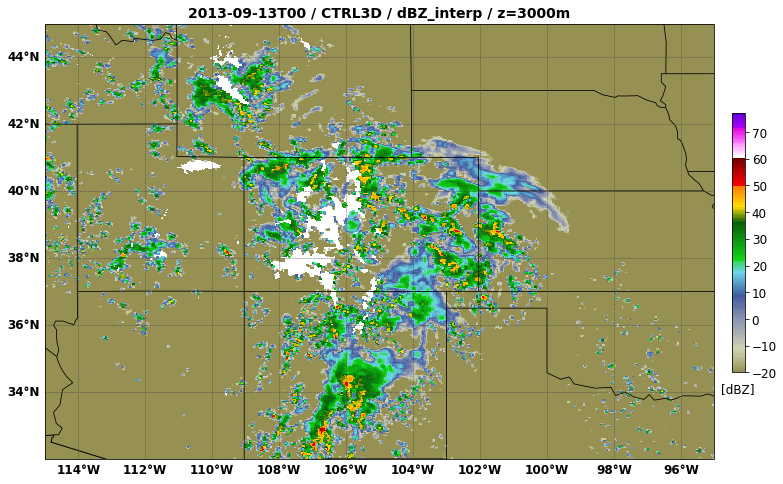

In [17]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = dbz_lev.data
plotting_lon = dbz_lev.XLONG
plotting_lat = dbz_lev.XLAT


## CWB colorbar:
# cf1 = ax1.contourf(plotting_lon, plotting_lat, plotting_var, 23, levels=clevs, colors=ccols)

## NWS colorbar:
cf1 = ax1.pcolormesh(plotting_lon, plotting_lat, plotting_var, cmap=ref_cmap, norm=ref_norm, shading='auto')


cf1_title = plt.title(np.datetime_as_string(dbz_lev.Time.data, unit='h') + ' / ' + 
                      wrf_sim_type + ' / ' + 
                      dbz_lev.name + ' / ' + 
                      'z=' + str(interp_vertical_lev) + dbz_lev.vert_units 
                     ,fontsize=14 
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_lev.Time.data, unit='h') + '_dbz.png', 
            bbox_inches='tight', 
            dpi=150)


In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
